<a href="https://colab.research.google.com/github/ThamilezaiAnanthakumar/Eye-State-Monitoring-using-EMG-artifact-as-useful-feature-in-EEG/blob/main/Eye_Open_Close_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.4 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/eye-state-classification-eeg-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eye-state-classification-eeg-dataset


In [3]:
import os

In [4]:
folder=os.listdir(path)

In [5]:
print(folder)

['EEG Eye State.arff', 'EEG_Eye_State_Classification.csv']


In [6]:
data='EEG_Eye_State_Classification.csv'

In [7]:
print(data)

EEG_Eye_State_Classification.csv


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import scipy
import mne

In [10]:
full_path = os.path.join(path, data)
df = pd.read_csv(full_path)
df.head()

AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   

        P8       T8      FC6       F4       F8      AF4  eyeDetection  
0  4222.05  4238.46  4211.28  4280.51  4635.90  4393.85             0  
1  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10             0  
2  4207.69  4222.05  4206.67  4282.05  4628.72  4389.23             0  
3  4217.44  4235.38  4210.77  4287.69  4632.31  4396.41             0  
4  4210.77  4244.10  4212.82  4288.21  4632.82  4398.46             0

In [11]:
df.shape

(14980, 15)

In [12]:
df.columns

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4', 'eyeDetection'],
      dtype='object')

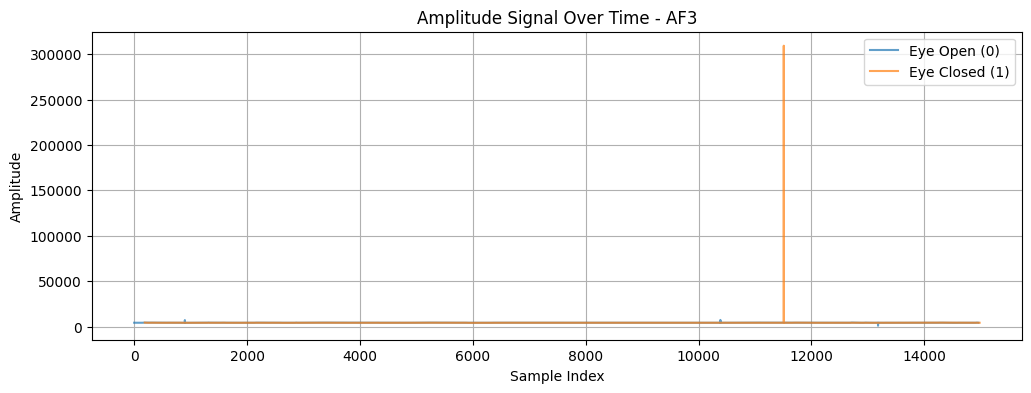

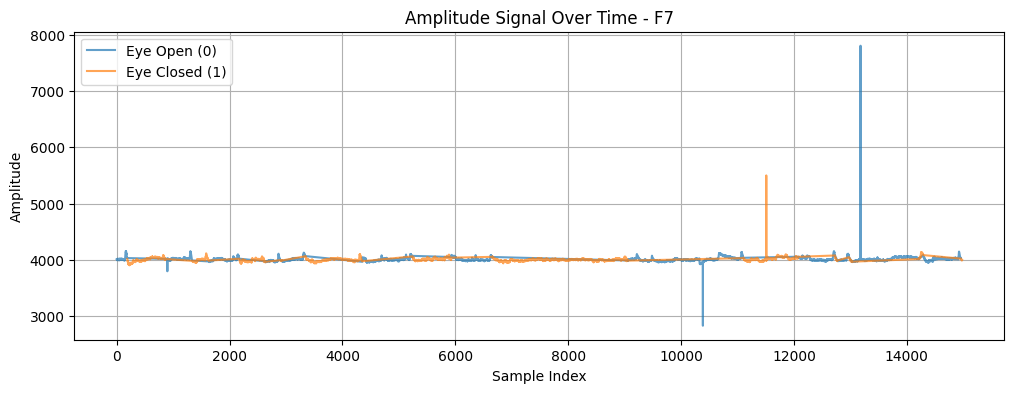

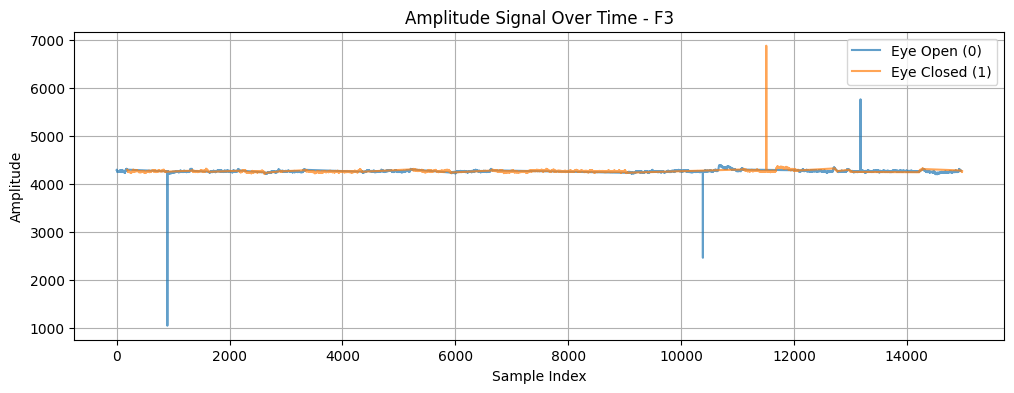

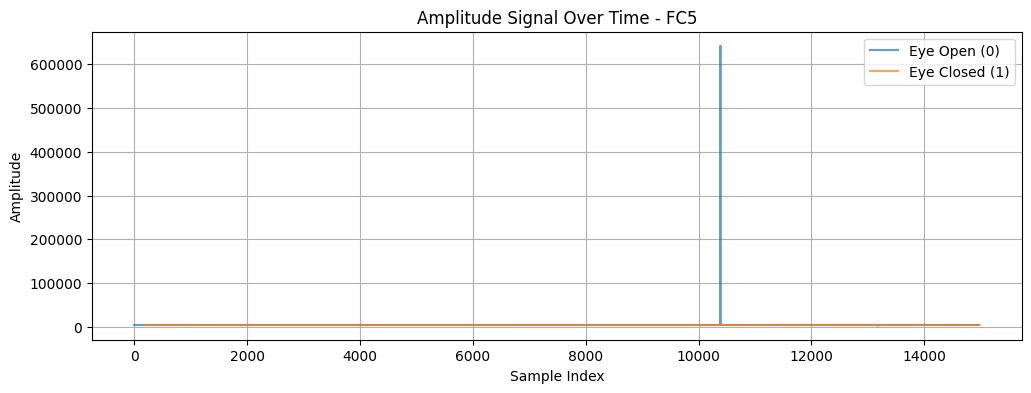

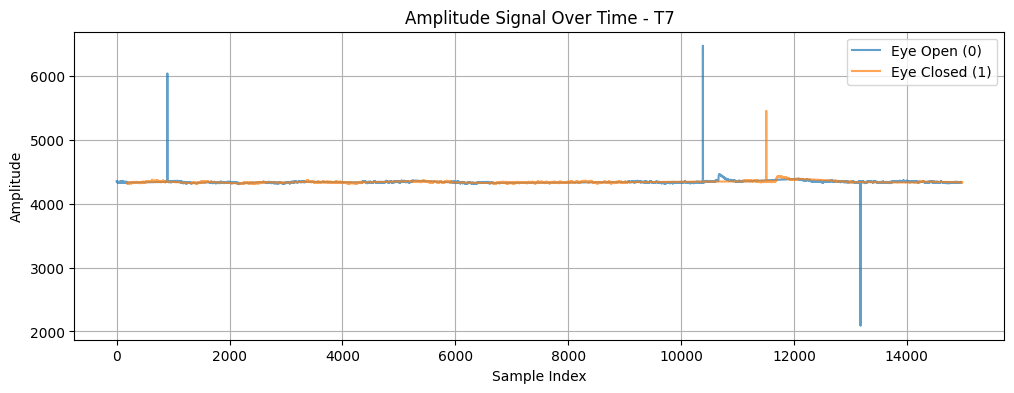

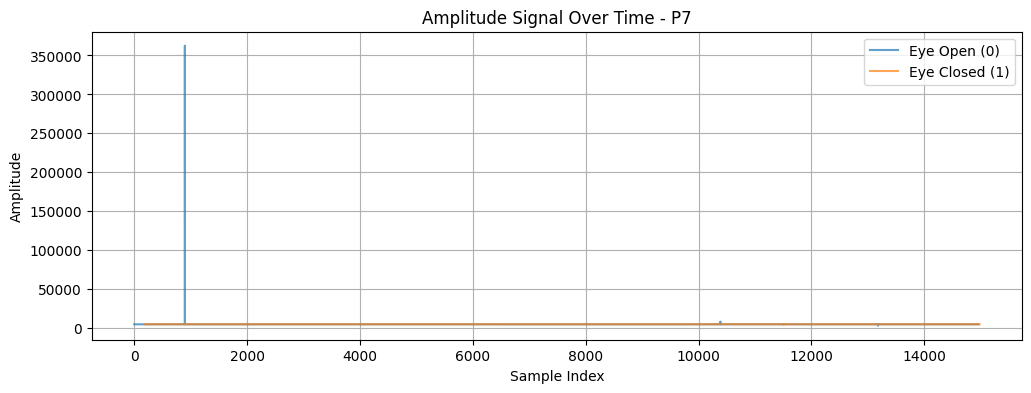

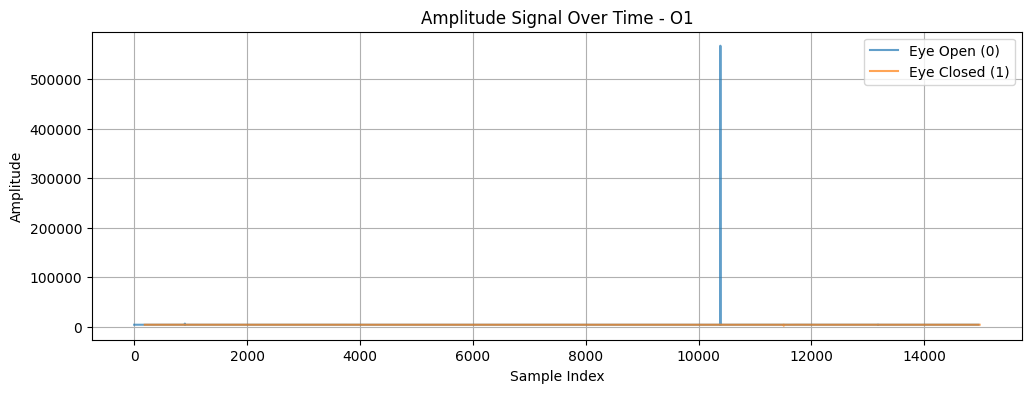

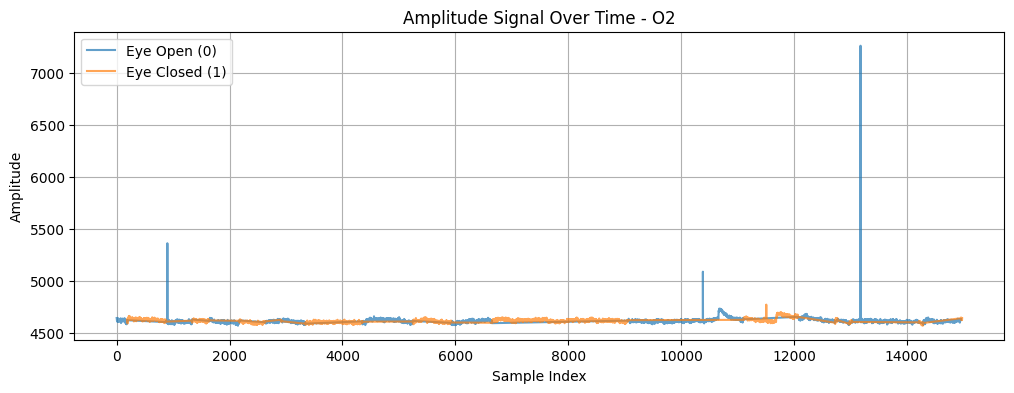

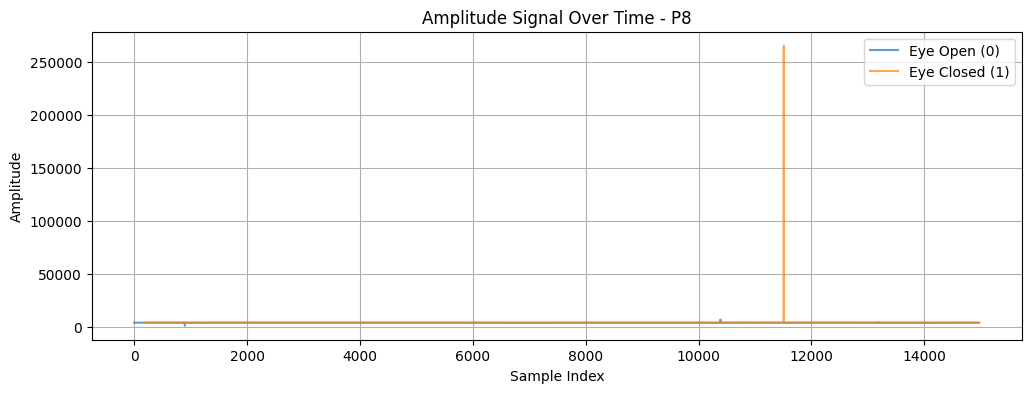

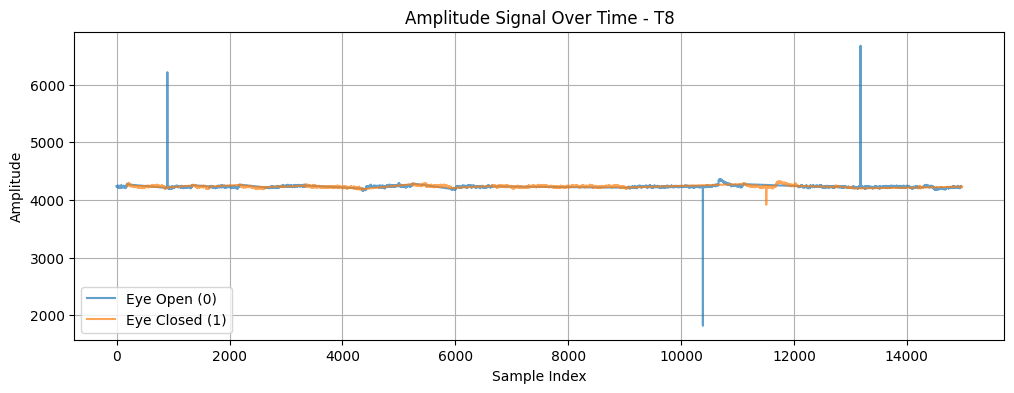

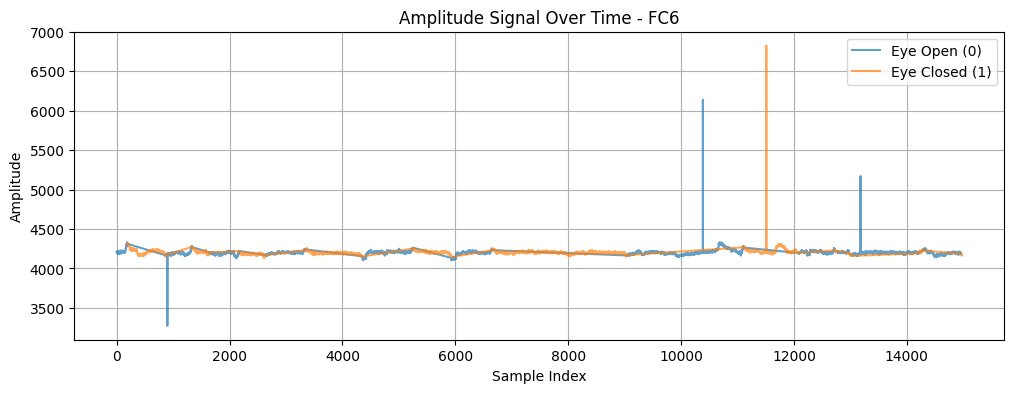

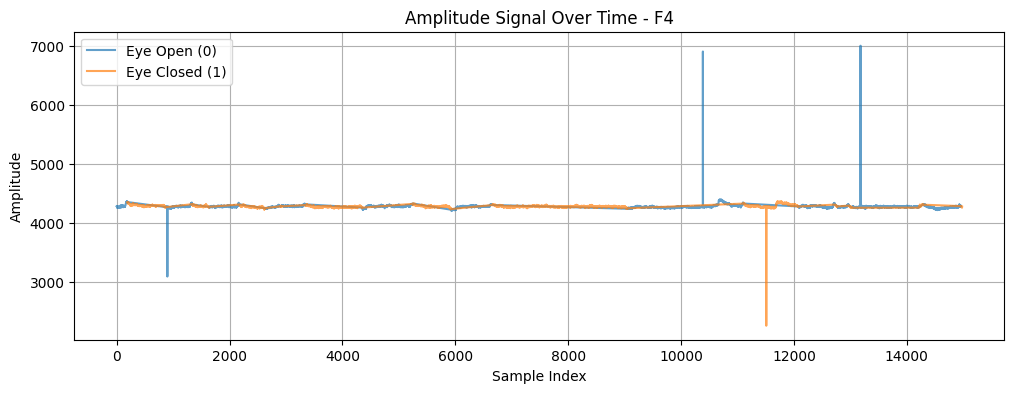

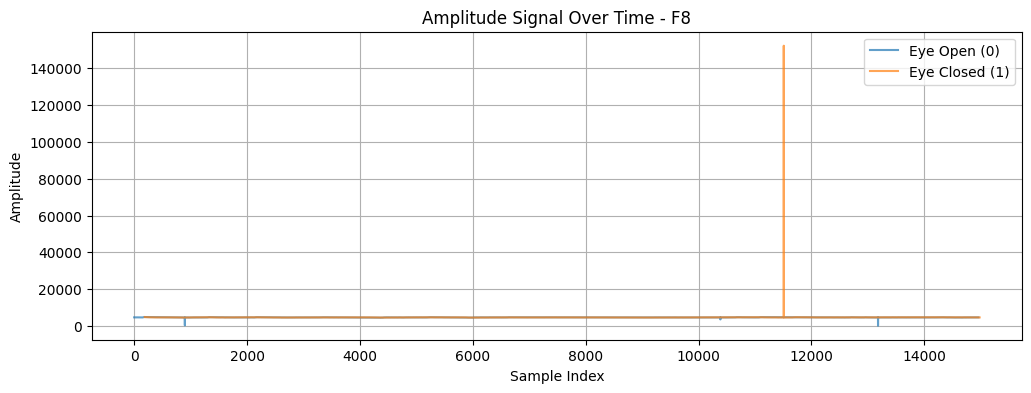

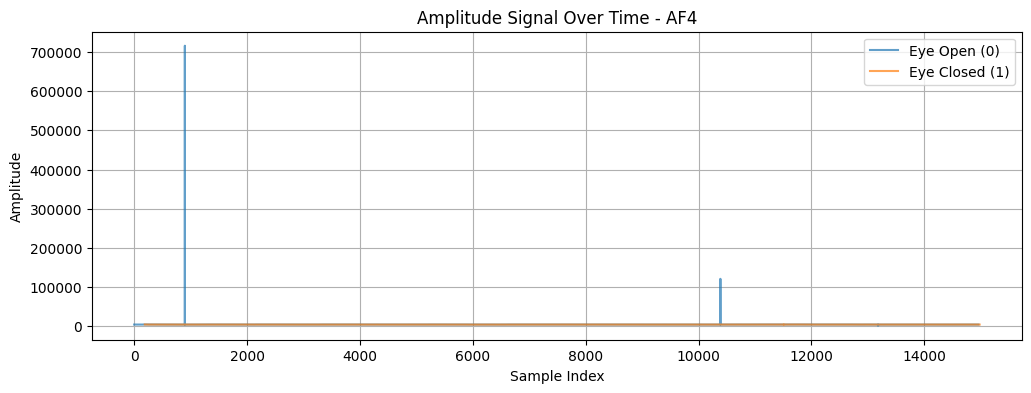

In [13]:


fs_original = 1000

channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

eye_open_df = df[df['eyeDetection'] == 0]
eye_closed_df = df[df['eyeDetection'] == 1]

for ch in channels:
    if ch in df.columns:
        plt.figure(figsize=(12, 4))

        plt.plot(eye_open_df.index, eye_open_df[ch], label='Eye Open (0)', alpha=0.7)
        plt.plot(eye_closed_df.index, eye_closed_df[ch], label='Eye Closed (1)', alpha=0.7)

        plt.title(f'Amplitude Signal Over Time - {ch}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()


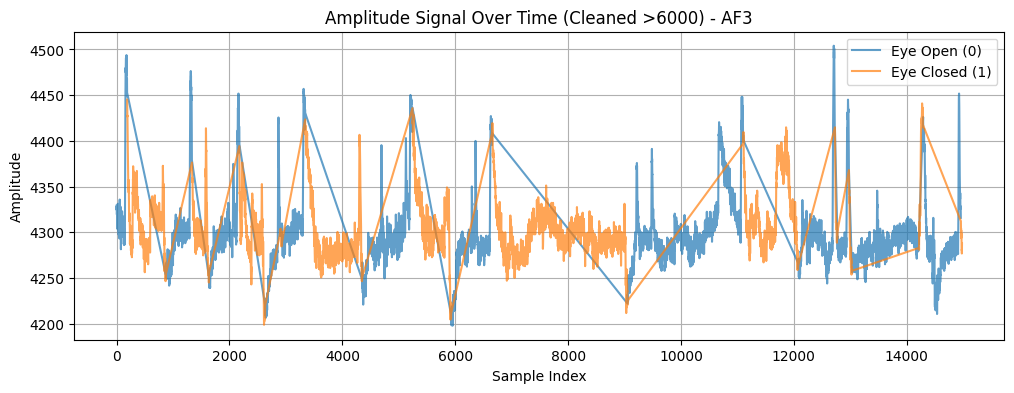

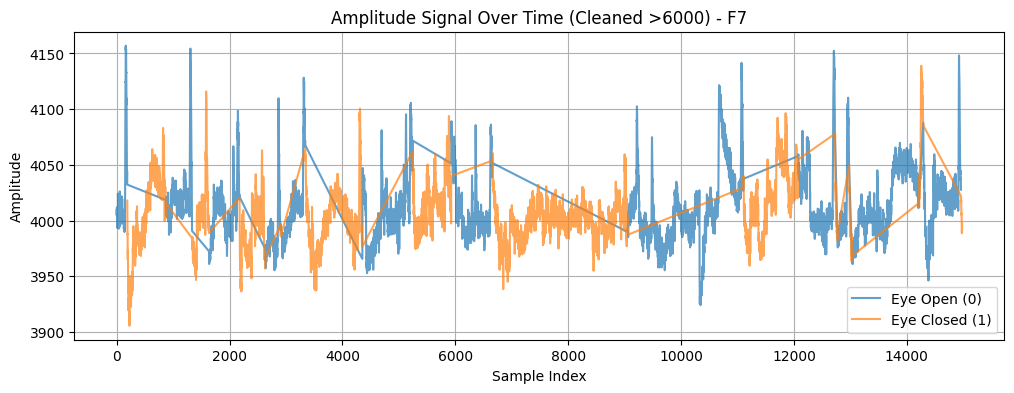

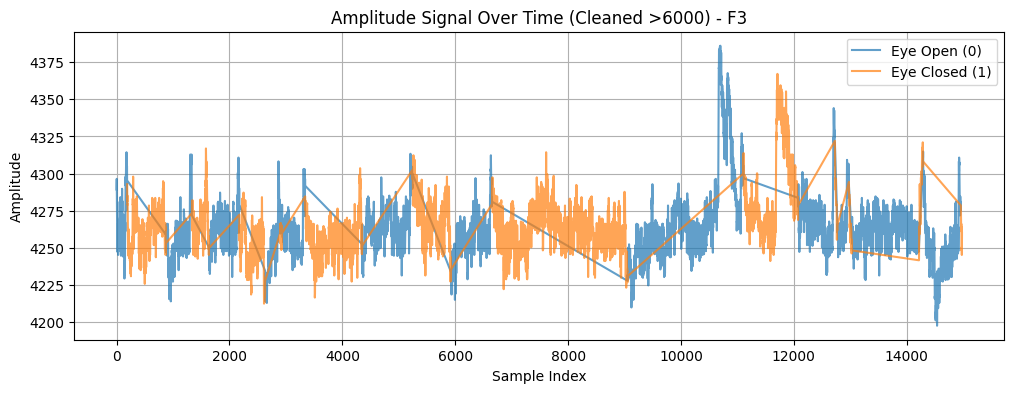

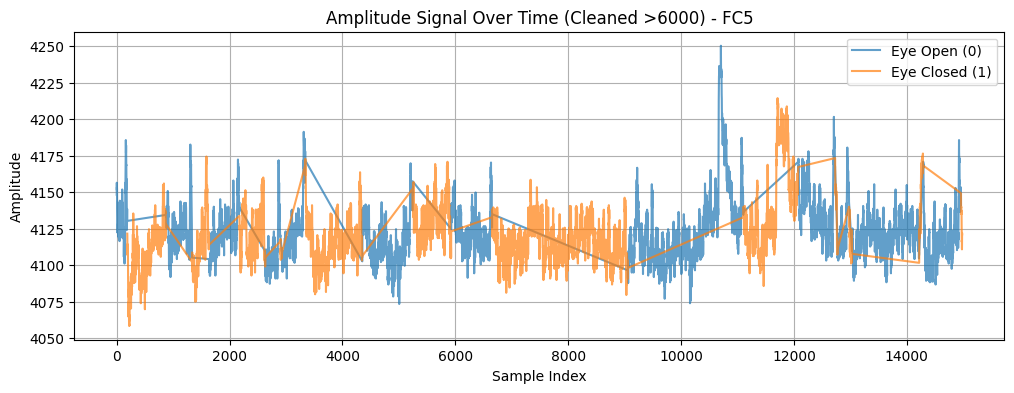

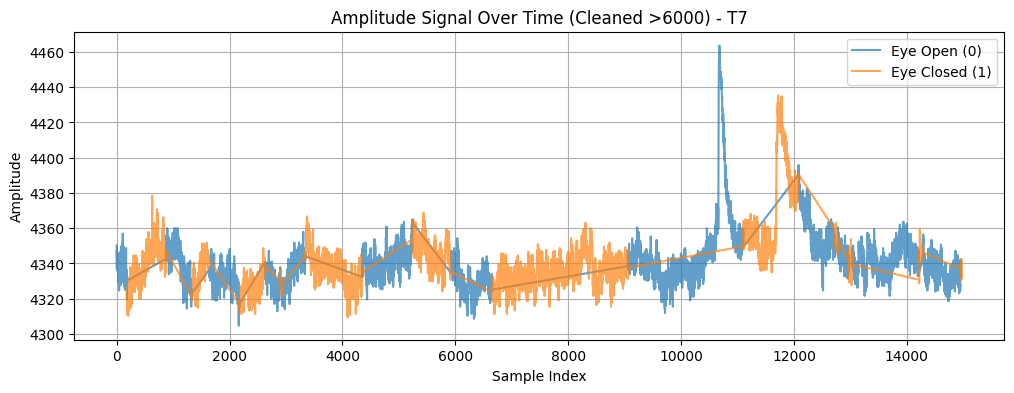

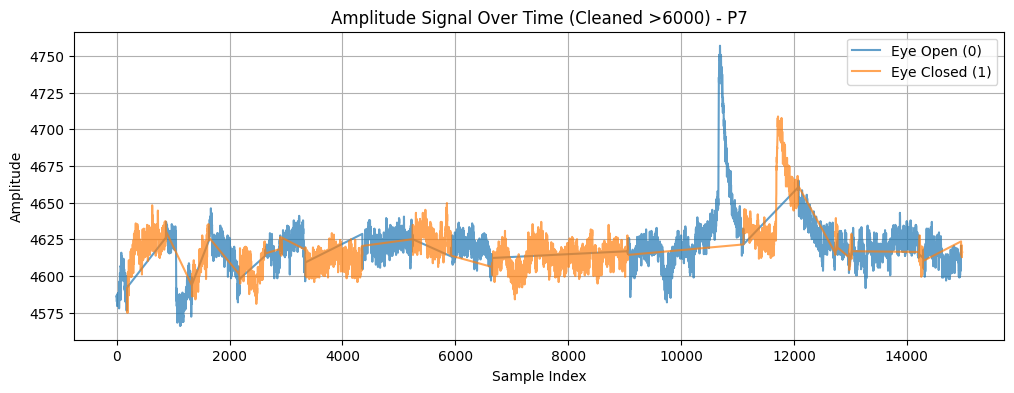

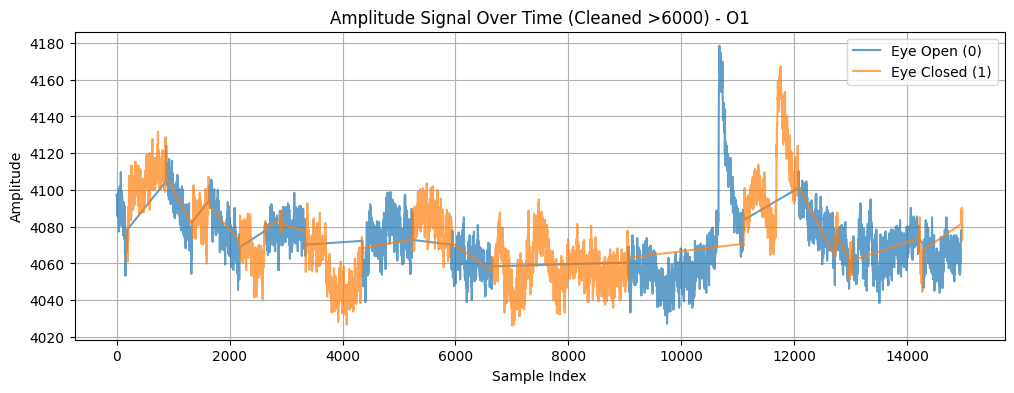

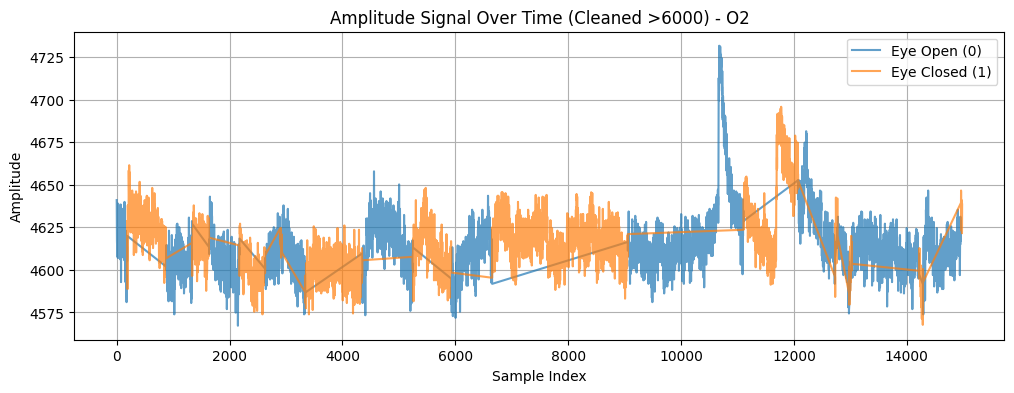

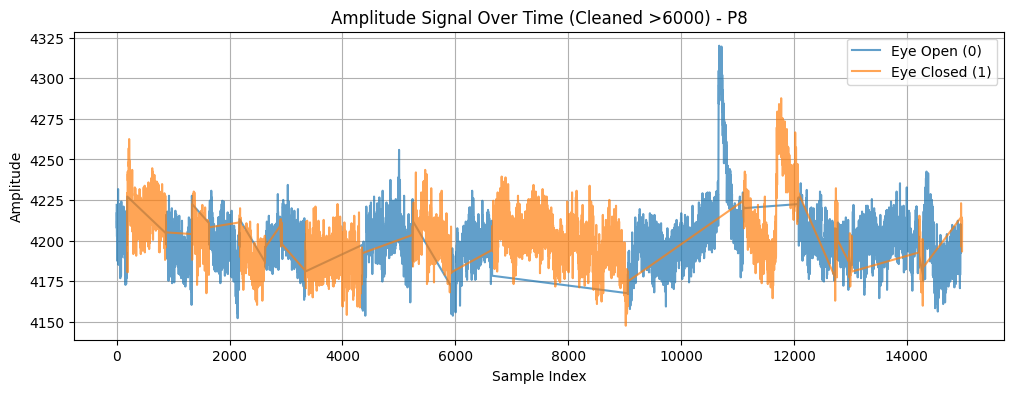

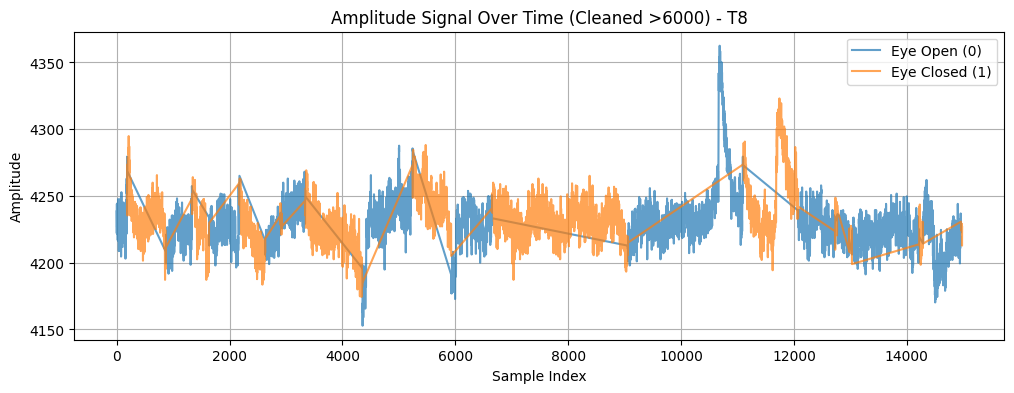

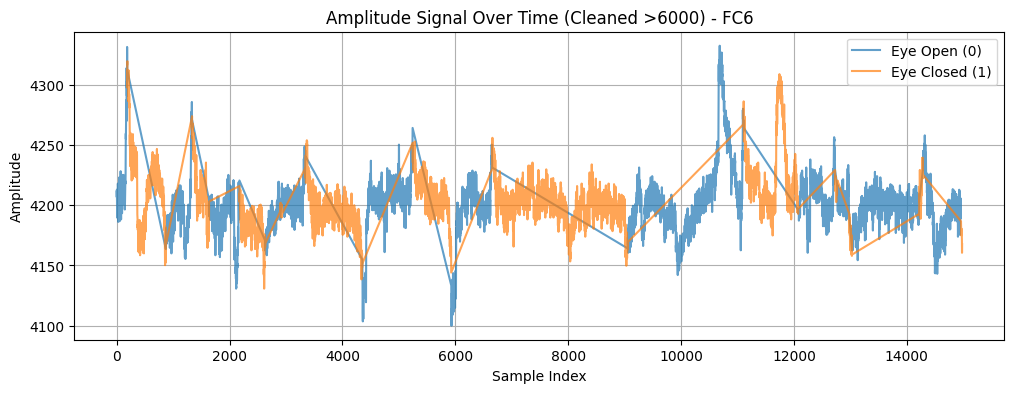

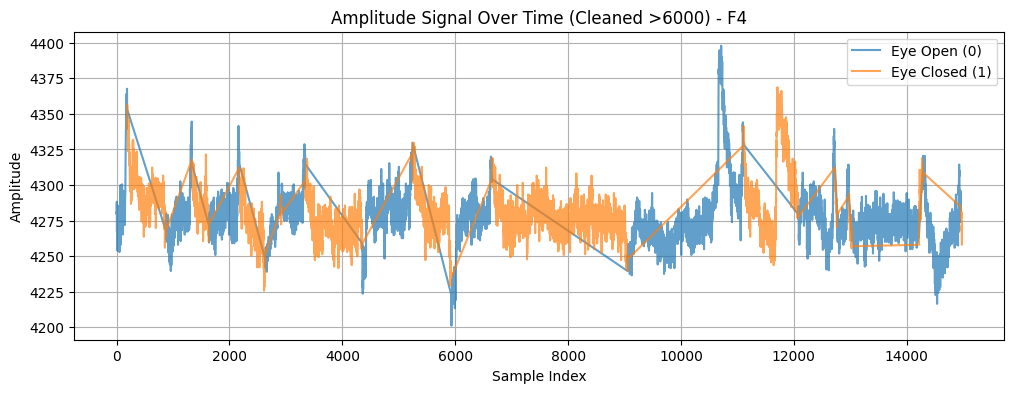

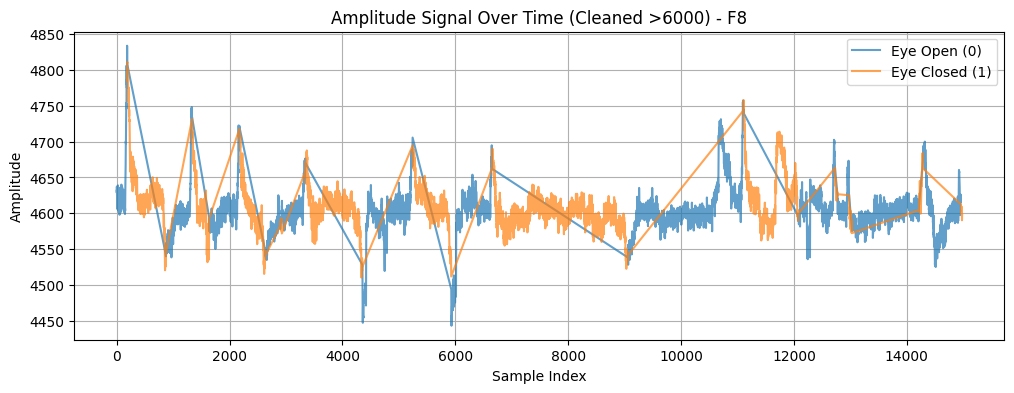

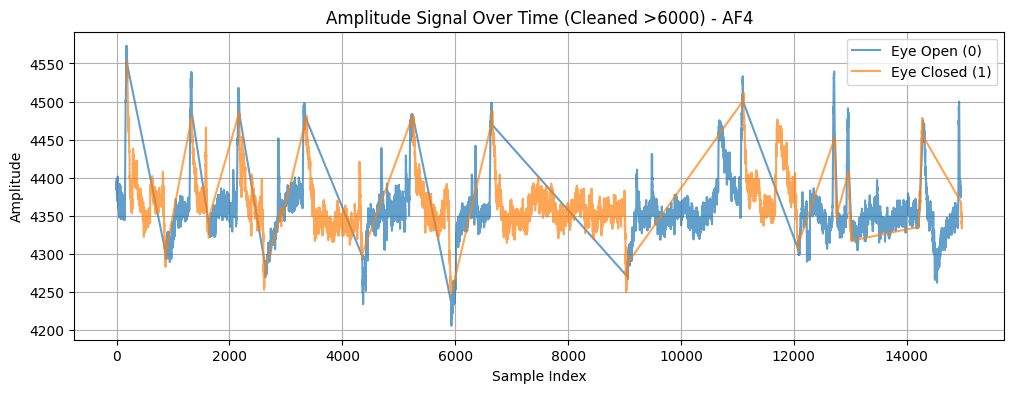

In [14]:
import matplotlib.pyplot as plt

fs_original = 1000
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# Filter out samples where any channel value > 6000
condition = (df[channels] <= 6000).all(axis=1)  # True if all channels <= 6000

clean_df = df[condition].copy()

eye_open_df = clean_df[clean_df['eyeDetection'] == 0]
eye_closed_df = clean_df[clean_df['eyeDetection'] == 1]

for ch in channels:
    if ch in clean_df.columns:
        plt.figure(figsize=(12, 4))
        plt.plot(eye_open_df.index, eye_open_df[ch], label='Eye Open (0)', alpha=0.7)
        plt.plot(eye_closed_df.index, eye_closed_df[ch], label='Eye Closed (1)', alpha=0.7)

        plt.title(f'Amplitude Signal Over Time (Cleaned >6000) - {ch}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()


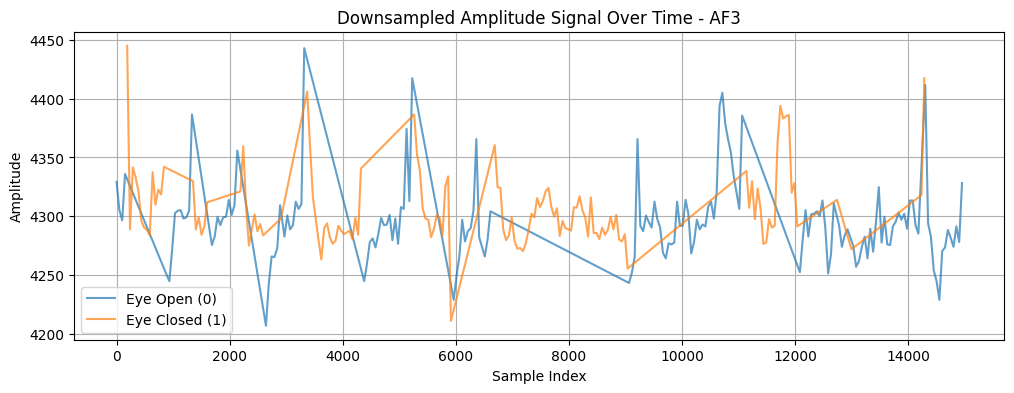

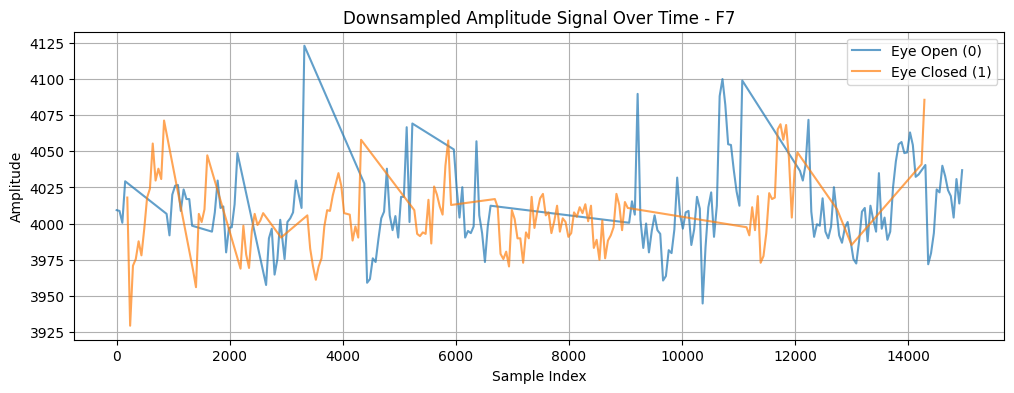

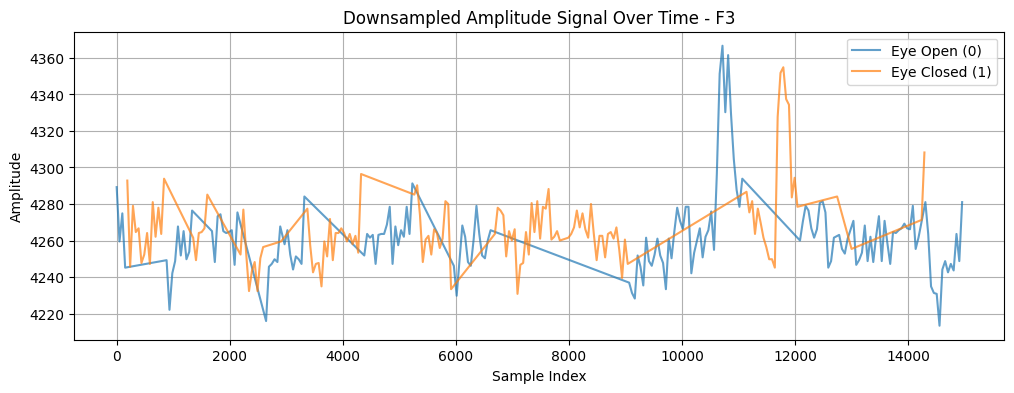

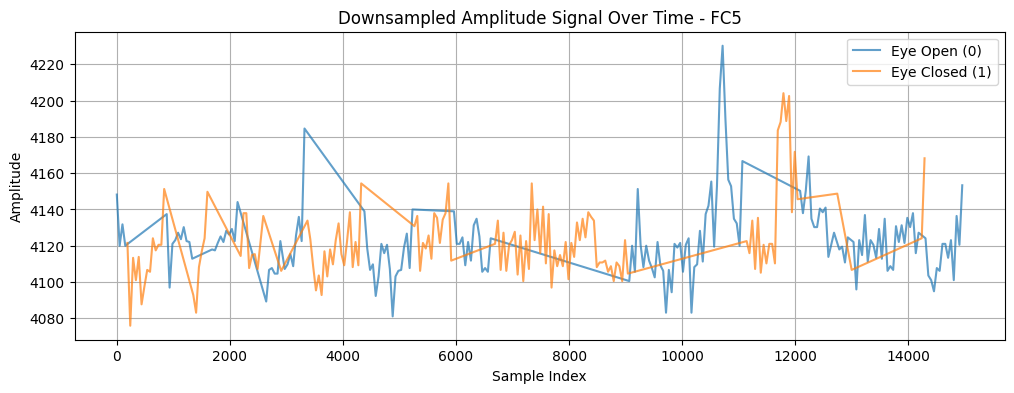

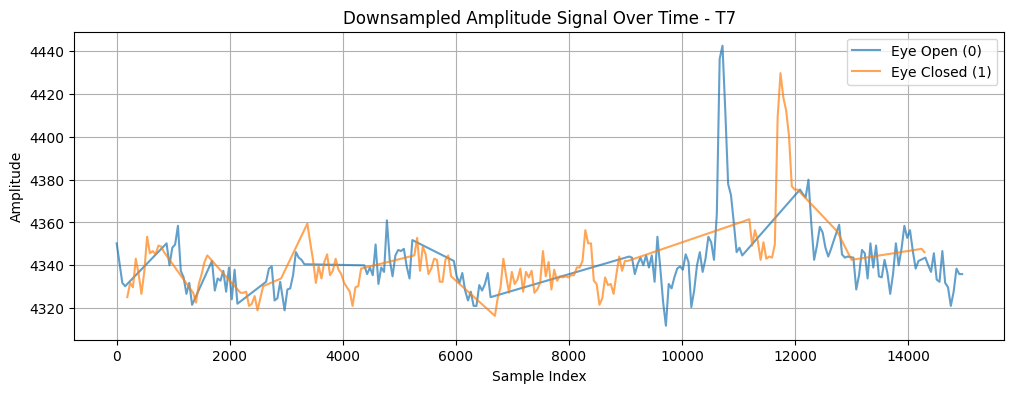

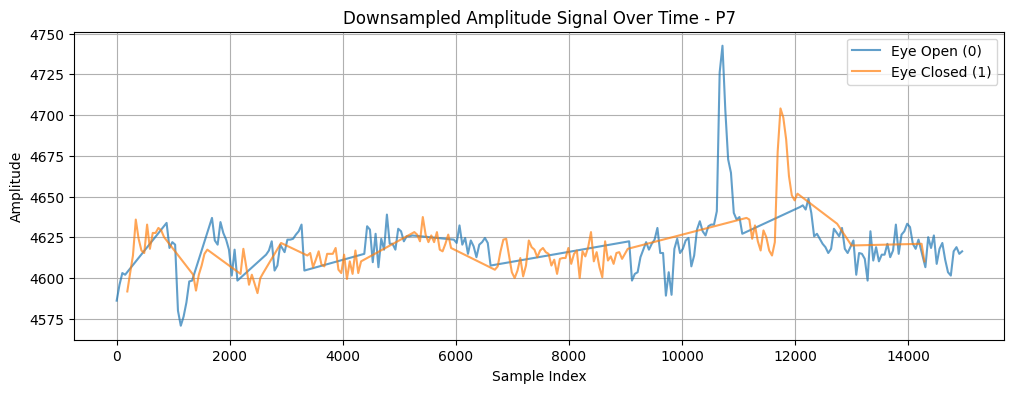

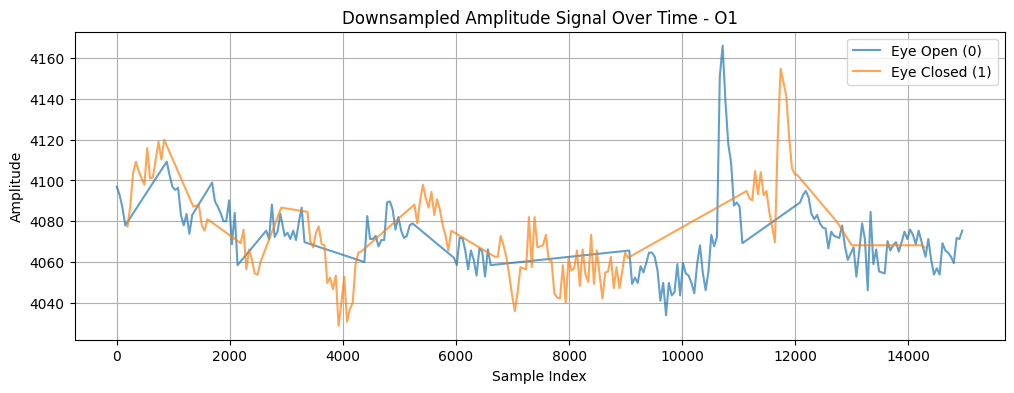

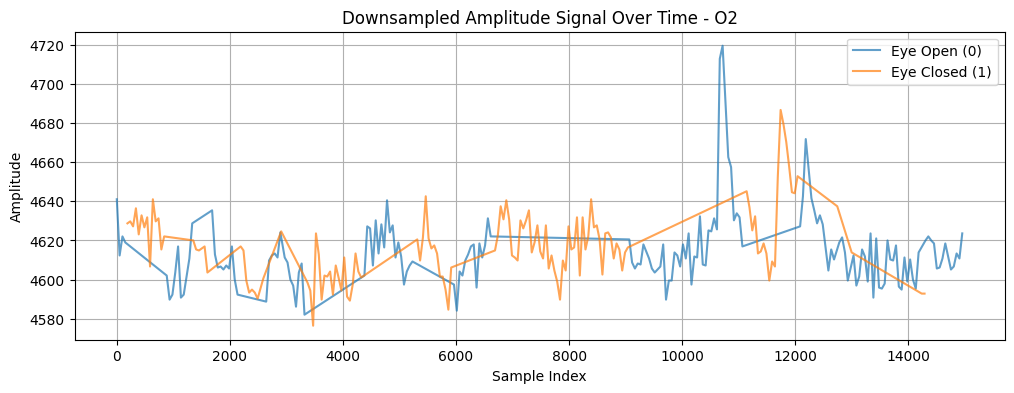

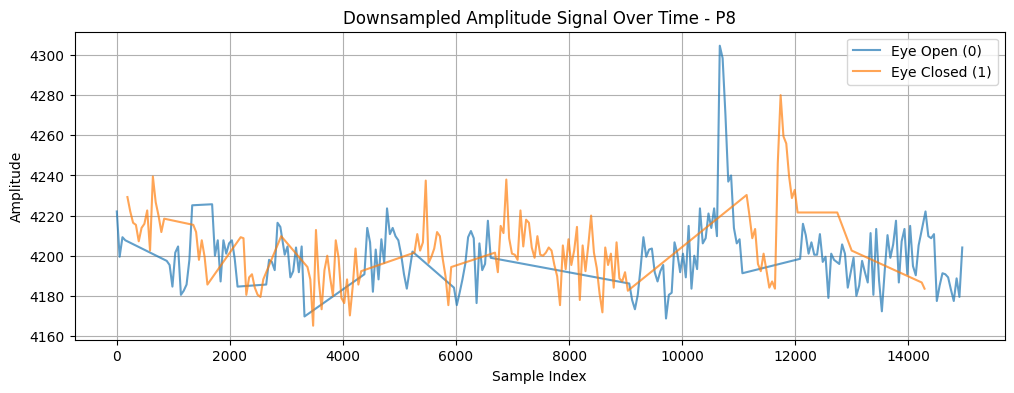

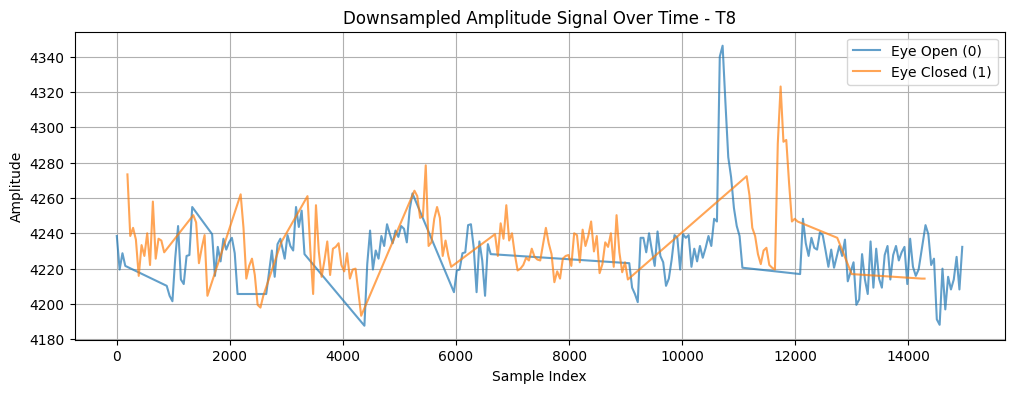

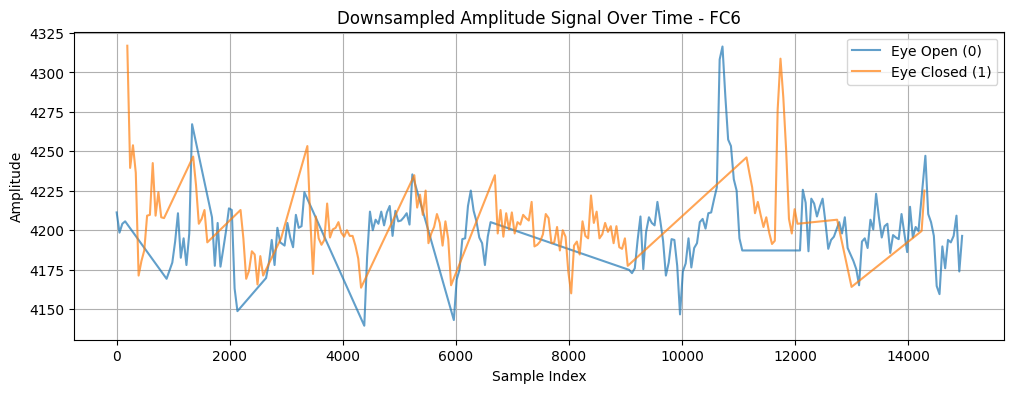

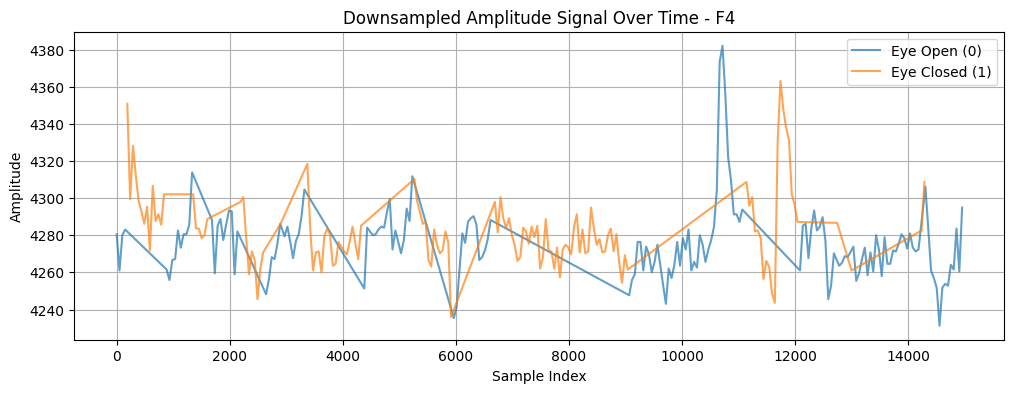

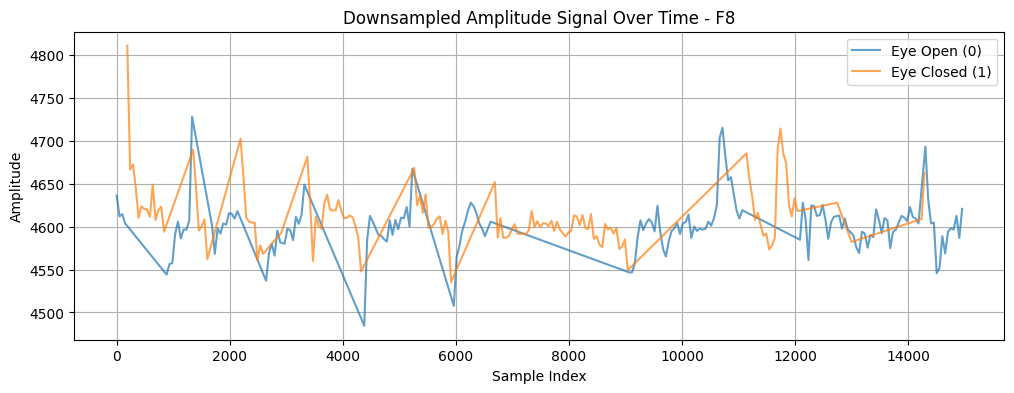

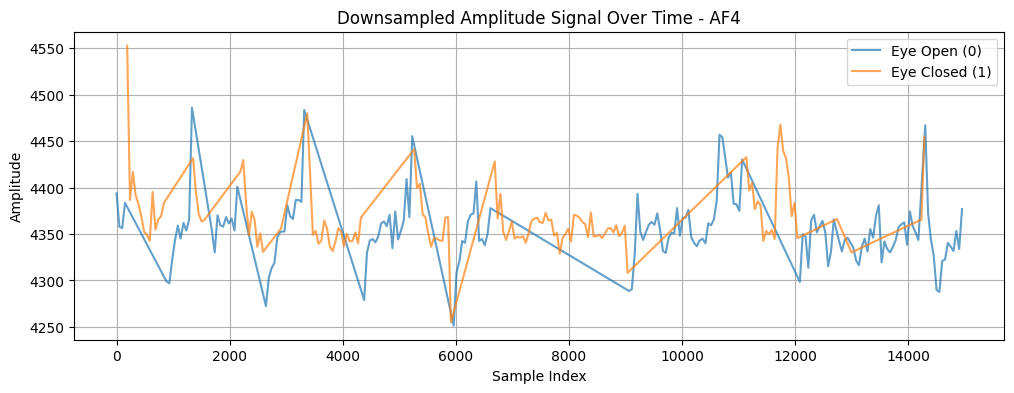

In [15]:
downsample_factor = 50

# Downsample by slicing every nth sample
eye_open_df_down = eye_open_df.iloc[::downsample_factor, :]
eye_closed_df_down = eye_closed_df.iloc[::downsample_factor, :]

for ch in channels:
    if ch in clean_df.columns:
        plt.figure(figsize=(12, 4))
        plt.plot(eye_open_df_down.index, eye_open_df_down[ch], label='Eye Open (0)', alpha=0.7)
        plt.plot(eye_closed_df_down.index, eye_closed_df_down[ch], label='Eye Closed (1)', alpha=0.7)

        plt.title(f'Downsampled Amplitude Signal Over Time - {ch}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()


In [16]:
from scipy.signal import welch

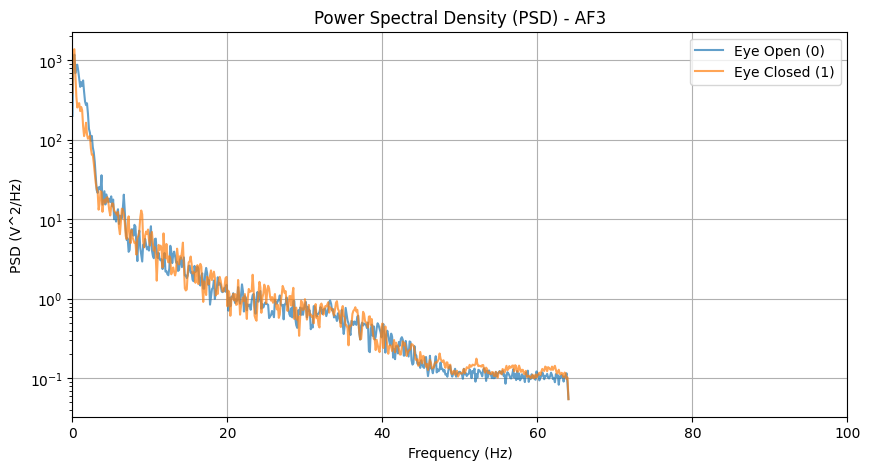

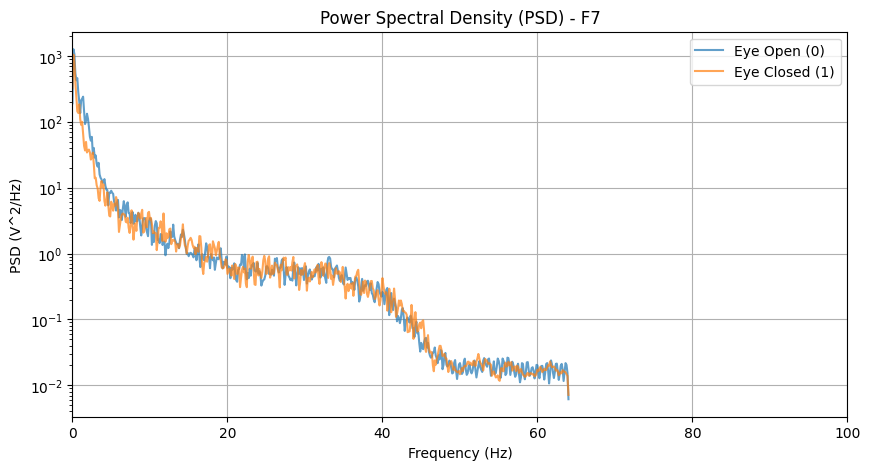

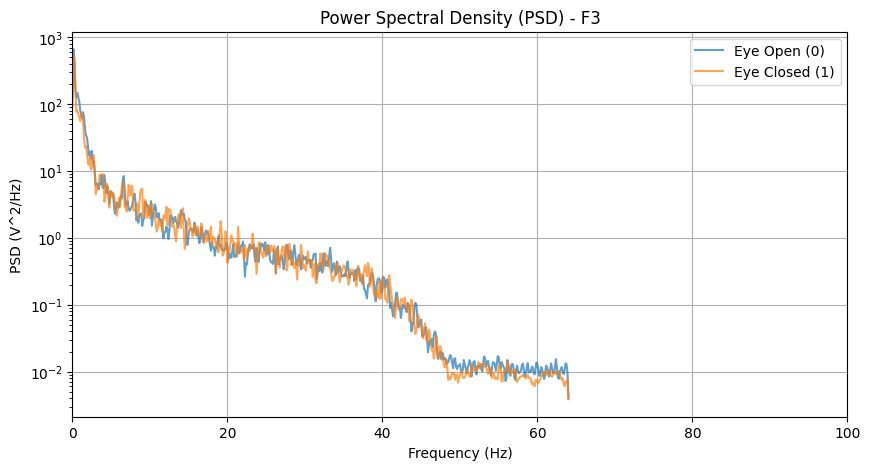

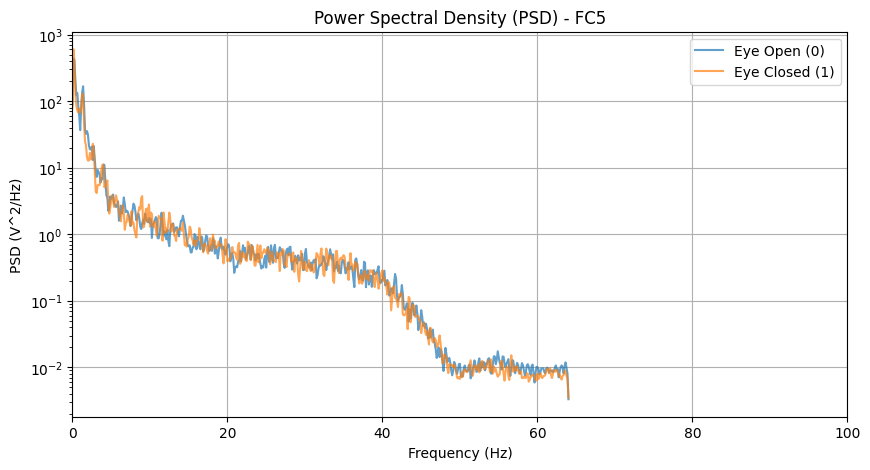

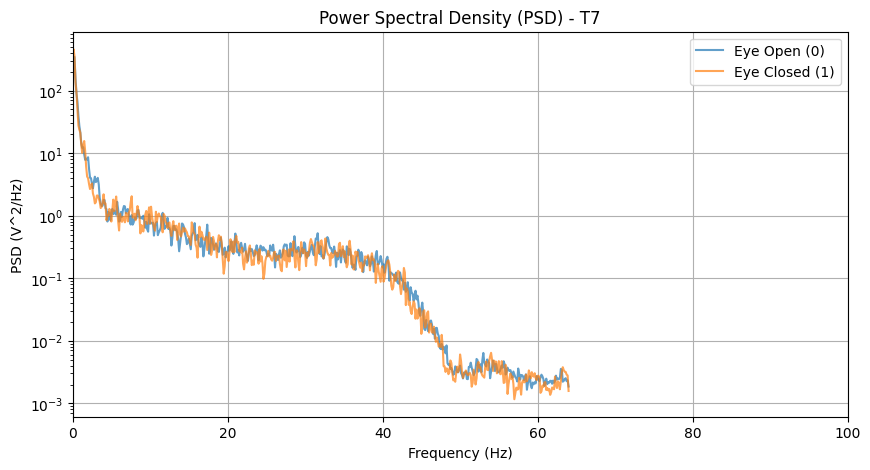

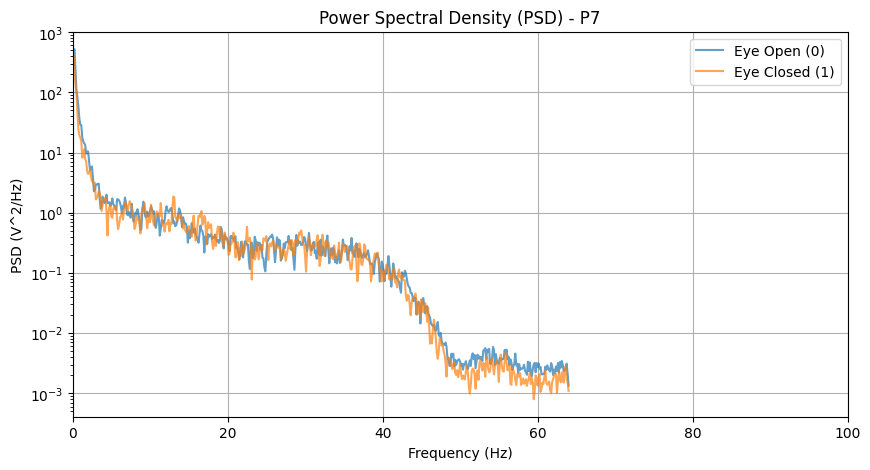

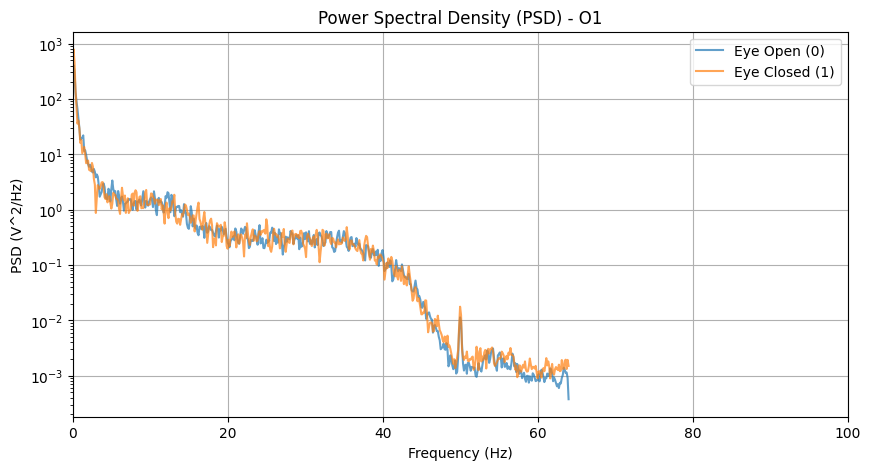

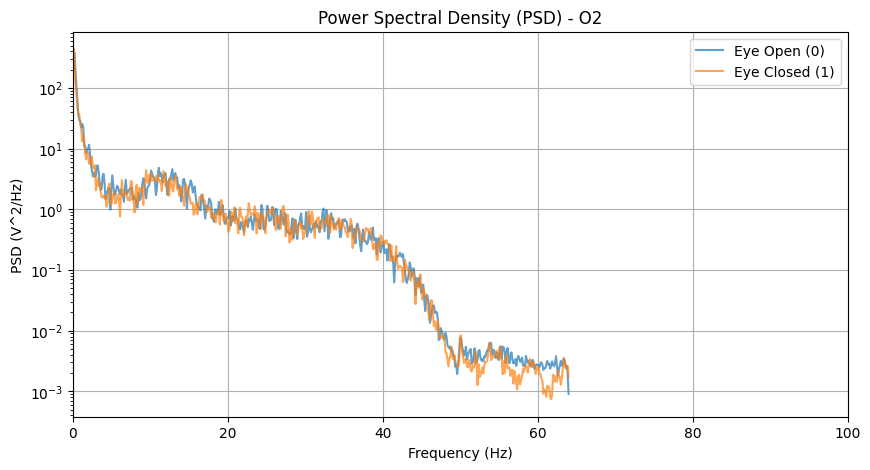

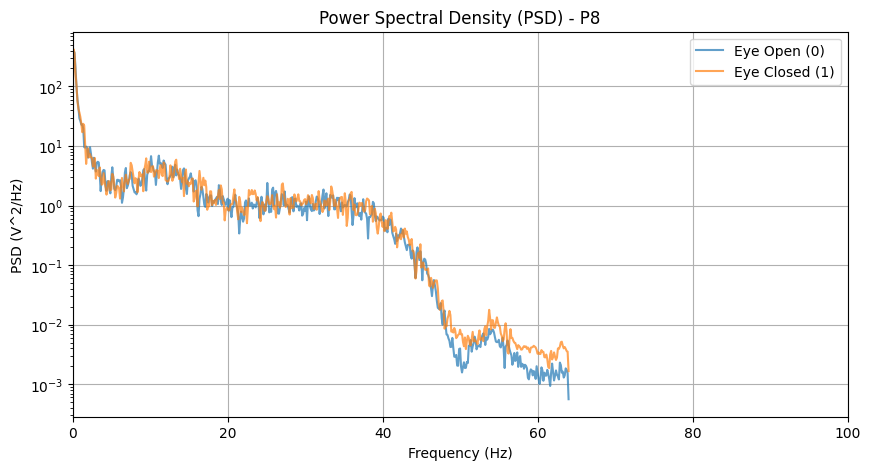

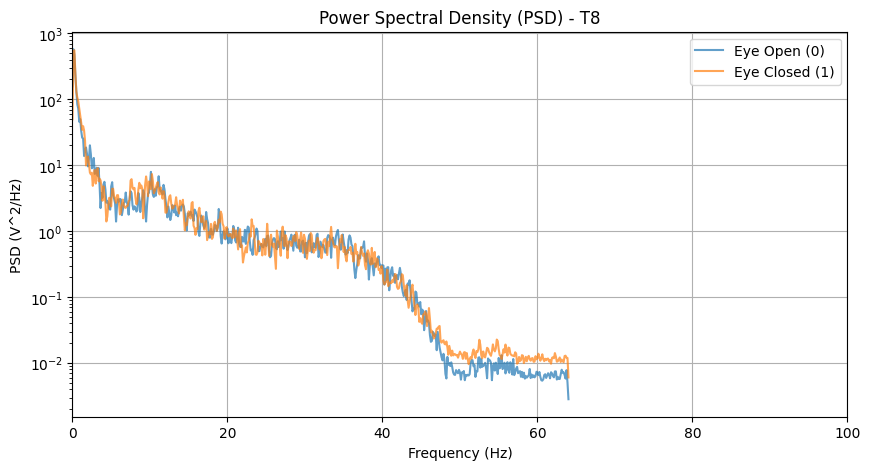

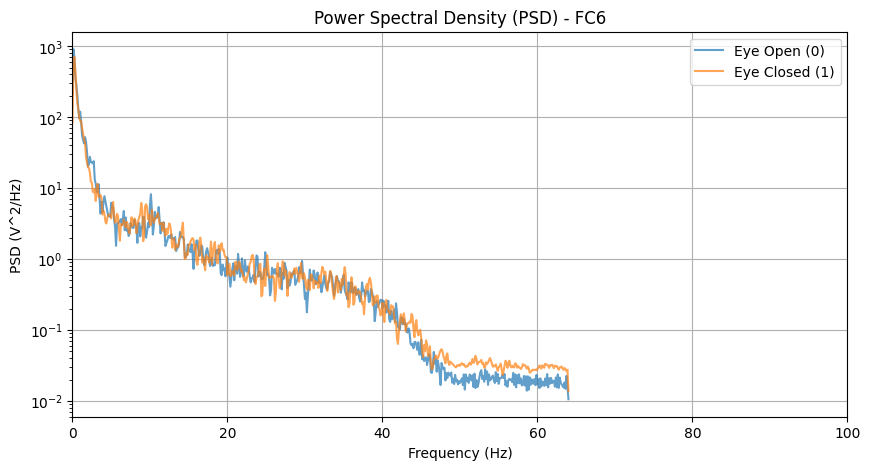

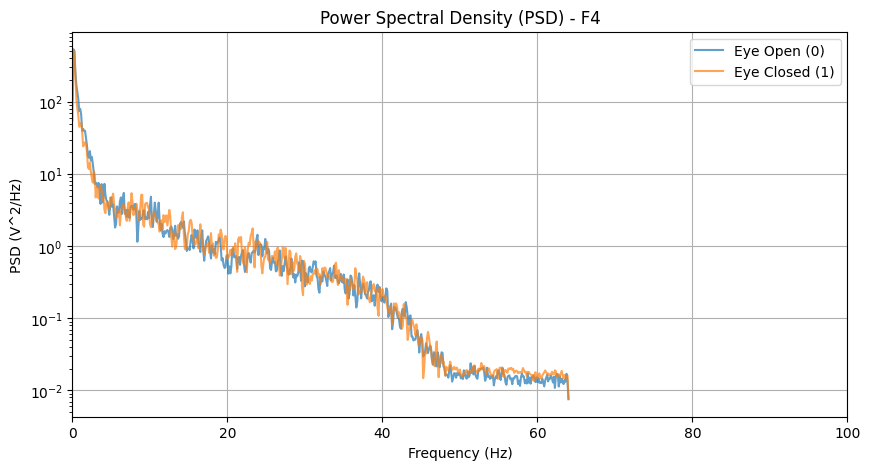

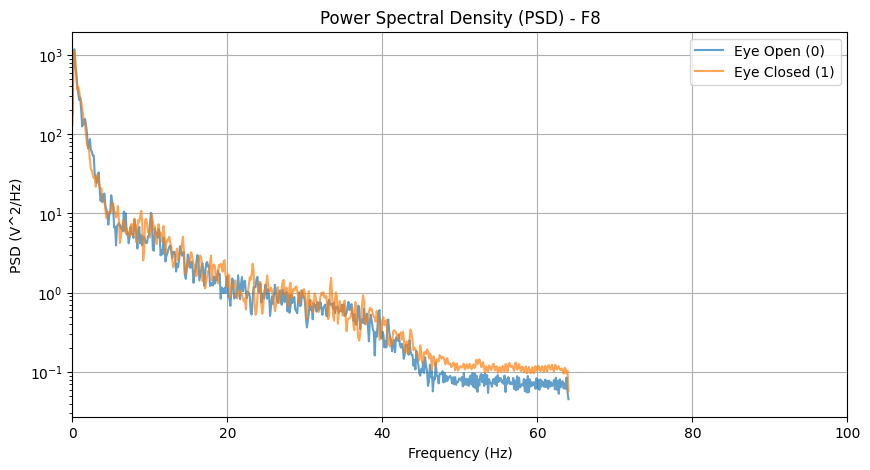

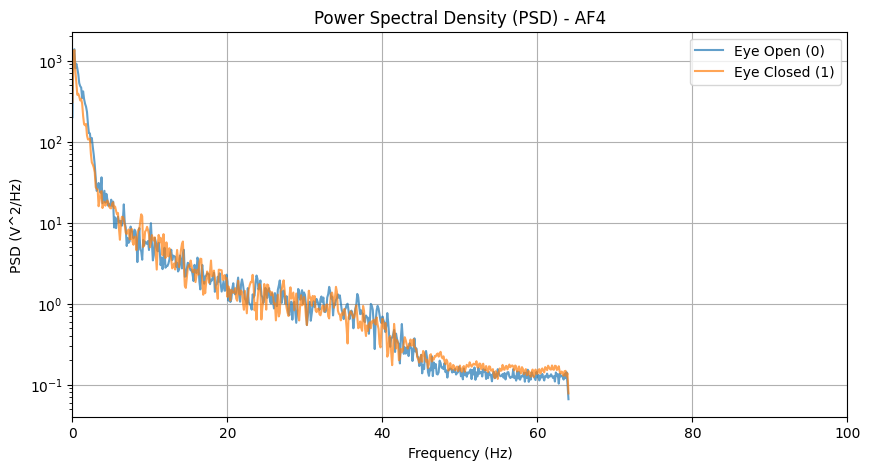

In [17]:
import matplotlib.pyplot as plt
from scipy.signal import welch

fs = 128

for ch in channels:
    if ch in clean_df.columns:
        # Extract signals
        open_signal = eye_open_df[ch].values
        closed_signal = eye_closed_df[ch].values

        # Compute PSD using Welch's method
        f_open, psd_open = welch(open_signal, fs=fs, nperseg=1024)
        f_closed, psd_closed = welch(closed_signal, fs=fs, nperseg=1024)

        plt.figure(figsize=(10, 5))
        plt.semilogy(f_open, psd_open, label='Eye Open (0)', alpha=0.7)
        plt.semilogy(f_closed, psd_closed, label='Eye Closed (1)', alpha=0.7)

        plt.title(f'Power Spectral Density (PSD) - {ch}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD (V^2/Hz)')
        plt.legend()
        plt.grid(True)
        plt.xlim(0, 100)  # Limit frequency axis for EEG typical range
        plt.show()


In [18]:
fs = 128

# Extract AF3 and AF4 as a NumPy array
data = clean_df[['AF3', 'AF4']].to_numpy().T  # shape (n_channels, n_samples)

# Create MNE RawArray with channel info
info = mne.create_info(ch_names=['AF3', 'AF4'], sfreq=fs, ch_types='eeg')
raw = mne.io.RawArray(data, info)

# Apply high-pass filter at 50 Hz
raw.filter(l_freq=50, h_freq=None, fir_design='firwin')

# Get the filtered data back into a DataFrame (transpose back to samples x channels)
filtered_data = raw.get_data().T
af_df = pd.DataFrame(filtered_data, columns=['AF3', 'AF4'])

print(af_df.head())


Creating RawArray with float64 data, n_channels=2, n_times=14976
    Range : 0 ... 14975 =      0.000 ...   116.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 50.00
- Lower transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 43.75 Hz)
- Filter length: 35 samples (0.273 s)

            AF3           AF4
0 -2.913225e-13  9.592327e-14
1 -5.946489e-01 -5.958362e-01
2  9.014358e-01  9.144764e-01
3 -6.764423e-01 -7.307074e-01
4  6.943789e-02  2.811673e-01
